# Курсовой проект для курса "Python для Data Science"

#### Подключение библиотек и скриптов

In [469]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
import seaborn as sns
from sklearn.preprocessing import LabelEncoder


import warnings
warnings.filterwarnings('ignore')

### Функции

In [470]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [471]:
def converting_bin(df):
    df_str_value=df.select_dtypes(include='object')
    df[df_str_value.columns+'_bin']=(df[df_str_value.columns]=='A').astype('int64')

In [472]:
def change_dataset(df):
        df.loc[df['Rooms']>=9,'Rooms']=df['Rooms'].median()
        df.loc[df['KitchenSquare']>30,'KitchenSquare']=df['KitchenSquare'].median()
        df.loc[df['LifeSquare'].isnull(),'LifeSquare']=df['LifeSquare'].median()
        df.loc[df['Square']<(df['LifeSquare']+df['KitchenSquare']),'LifeSquare']=df['Square']-df['KitchenSquare']
        df.loc[df['HouseFloor']>60,'HouseFloor']=df['Floor']
        df.loc[df['Floor']>df['HouseFloor'],'HouseFloor']=df['Floor']
        df.loc[df['HouseYear']>2020,'HouseYear']=2020
        df[df['Rooms']==0]['Rooms']=df['Rooms'].median()

#### Пути к директориям и файлам

In [473]:
DATASET = 'train.csv'
DATASET_TEST = 'test.csv'

### Загрузка данных

#### Описание датасета:
* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [474]:
df=pd.read_csv(DATASET)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [475]:
df.shape

(10000, 20)

## Анализ Датасета

### Типы данных

In [476]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


### Обзор количественных переменных

In [477]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


максимальные значения явно не корректны

### Обзор незаполненых значений

In [478]:
len(df)-df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

признак Healthcare_1  имеет 4798 не заполненых значений, для модели учитываться не будет. LifeSquare 2113 дозаполним медианным значением.

### Обзор номинативных переменных

In [479]:
df_str_value=df.select_dtypes(include='object')
df_str_value.head(3)

,Ecology_2,Ecology_3,Shops_2
0,B,B,B
1,B,B,B
2,B,B,B


In [480]:
print('Ecology_2'+"\n",df['Ecology_2'].value_counts())
print("-"*10)
print('Ecology_3'+"\n",df['Ecology_3'].value_counts())
print("-"*10)
print('Shops_2'+"\n",df['Shops_2'].value_counts())

Ecology_2
 B    9903
A      97
Name: Ecology_2, dtype: int64
----------
Ecology_3
 B    9725
A     275
Name: Ecology_3, dtype: int64
----------
Shops_2
 B    9175
A     825
Name: Shops_2, dtype: int64


данные признаки имеют два вида A, B. применим бинарное преобразование A=0, B=1

### Проверка корректности, корректировка данных

In [481]:
df[df['Rooms']>=9]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


In [482]:
df[df['Square']<(df['LifeSquare']+df['KitchenSquare'])].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229


Значения LifeSquare > Square-KitchenSquare  скорректируем до LifeSquare = Square-KitchenSquare наличе дополнительных площадей учитывать не будем на модель это не повлияет

значение Rooms для данных приведем к значению медианному значению

LifeSquare имеет пустые значения дозаполним медианным значением

значения Floor> HouseFloor также приведем к значению HouseFloor=Floor

в датасете присутствуют значения 2020 предпологаем что это строящееся дома и данные корректны значения выще 2020 считаем не корректными

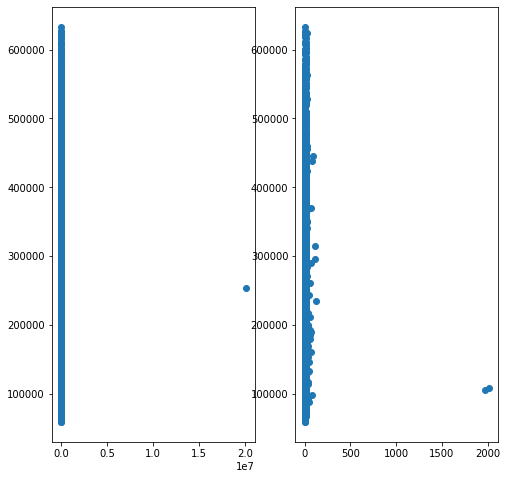

In [483]:
plt.figure(figsize = (8,8))

plt.subplot(121)
plt.scatter(df.HouseYear,df.Price)
plt.subplot(122)
plt.scatter(df.KitchenSquare,df.Price)
plt.show()

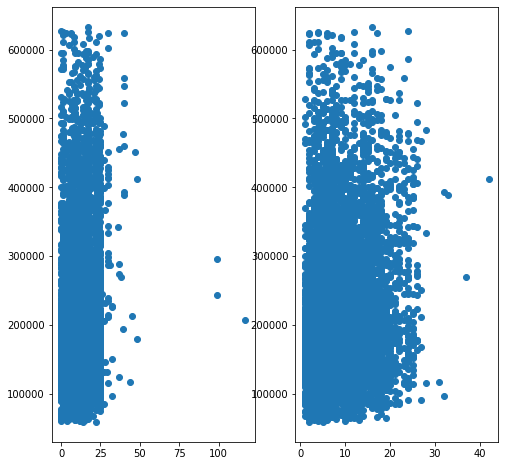

In [484]:
plt.figure(figsize = (8,8))

plt.subplot(121)
plt.scatter(df.HouseFloor,df.Price)
plt.subplot(122)
plt.scatter(df.Floor,df.Price)
plt.show()


In [485]:
df[df['HouseFloor']>70]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6131,10806,5,1.0,51.944587,48.709601,1.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515
8599,9300,74,2.0,71.747869,74.579809,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
8854,78,30,2.0,65.773749,66.811789,1.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520


In [486]:
change_dataset(df) # изменение датасета по вышеописанным параметрам

Square выше 250 также принимаем как некорректные удаляем из датасета 4 позиции

In [487]:
df[df['Square']>250].shape

(4, 20)

In [488]:
df=df[df['Square']<250]

In [489]:
df[df['Square']>250].shape

(0, 20)

#### Результат

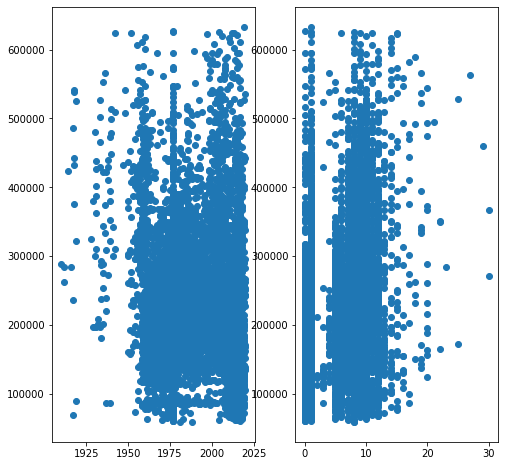

In [490]:
plt.figure(figsize = (8,8))

plt.subplot(121)
plt.scatter(df.HouseYear,df.Price)
plt.subplot(122)
plt.scatter(df.KitchenSquare,df.Price)
plt.show()

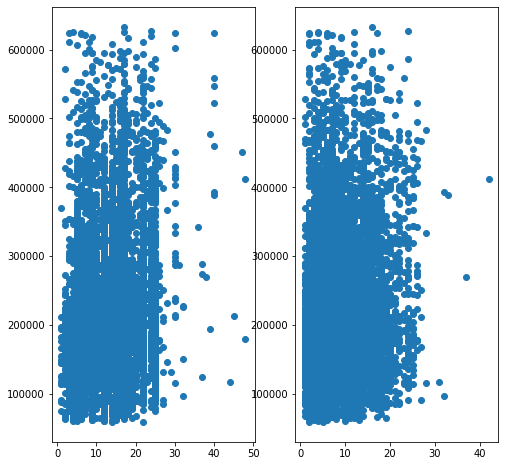

In [491]:
plt.figure(figsize = (8,8))

plt.subplot(121)
plt.scatter(df.HouseFloor,df.Price)
plt.subplot(122)
plt.scatter(df.Floor,df.Price)
plt.show()


### Преобразование номинативных переменных в бинарные

в обзоре было определено наличие значений A,B преобразовываем в 0,1 соответственно.

In [492]:
converting_bin(df)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,7976,5,NaN,0,11,B,184966.930730,0,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.450063,0,0,0
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.908524,0,0,0
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.227217,0,0,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531644,0,0,0


###  Анализ целевой переменной

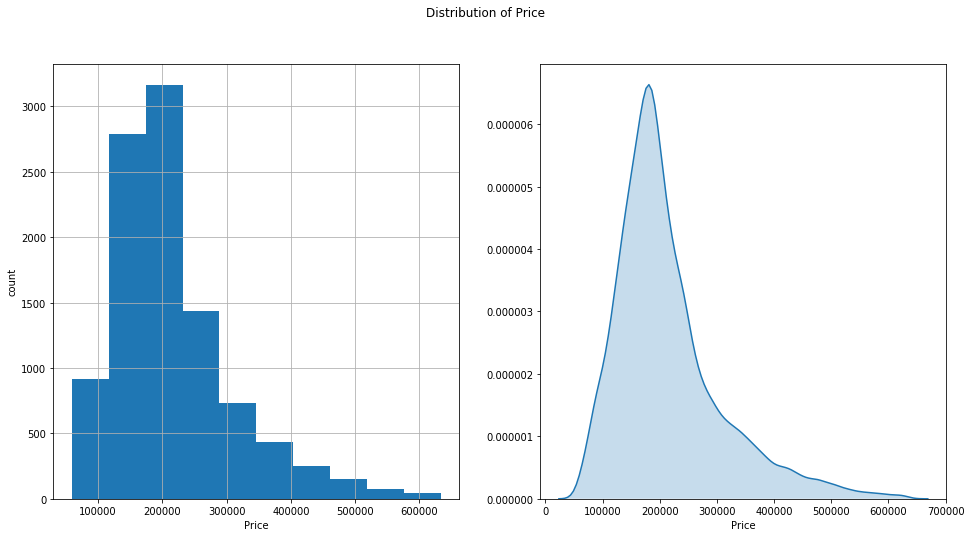

In [493]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist()
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

### Создание дополнительных признаков

In [494]:
val=df['DistrictId'].unique()
val.shape


(205,)

In [495]:
for i in val:
      df.loc[df['DistrictId']==i,'value_price']=(df[df['DistrictId']==i]['Price'].median()/df[df['DistrictId']==i]['Square'].median())


In [496]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,value_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,NaN,0,11,B,184966.930730,0,0,0,4273.980146
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,0,0,0,4395.277115
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,0,0,0,4527.229293
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,0,0,0,2955.306014
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,0,0,0,3942.103724


In [497]:
len(df)-df.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
Ecology_2_bin       0
Ecology_3_bin       0
Shops_2_bin         0
value_price         0
dtype: int64

In [498]:
target_name = 'Price' #LifeSquare
feature_names=['DistrictId','value_price','Rooms','Square','KitchenSquare','Floor','HouseFloor','HouseYear','Ecology_1','Social_2',
               'Social_3','Helthcare_2','Shops_1','Ecology_2_bin','Ecology_3_bin','Shops_2_bin']


In [499]:
df = df[feature_names+[target_name]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9996 entries, 0 to 9999
Data columns (total 17 columns):
DistrictId       9996 non-null int64
value_price      9996 non-null float64
Rooms            9996 non-null float64
Square           9996 non-null float64
KitchenSquare    9996 non-null float64
Floor            9996 non-null int64
HouseFloor       9996 non-null float64
HouseYear        9996 non-null int64
Ecology_1        9996 non-null float64
Social_2         9996 non-null int64
Social_3         9996 non-null int64
Helthcare_2      9996 non-null int64
Shops_1          9996 non-null int64
Ecology_2_bin    9996 non-null int64
Ecology_3_bin    9996 non-null int64
Shops_2_bin      9996 non-null int64
Price            9996 non-null float64
dtypes: float64(7), int64(10)
memory usage: 1.4 MB


In [500]:
matrix_cor=df.corr()
matrix_cor.style.background_gradient(cmap='coolwarm')
#matrix_cor.loc[matrix_cor['Price']>0.2,'Price']

,DistrictId,value_price,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
DistrictId,1,0.500765,0.0767465,-0.0284271,0.247577,-0.12014,-0.20645,-0.20068,0.0651505,0.167537,0.136583,0.306128,0.174467,0.0934271,0.0274654,0.021039,0.265145
value_price,0.500765,1,0.119959,-0.0434121,0.35413,-0.0671338,-0.134122,-0.214765,0.00226688,0.427874,0.0999422,0.437303,0.264361,0.01743,0.097258,-0.163591,0.530344
Rooms,0.0767465,0.119959,1,0.755541,0.1332,-0.00596184,-0.0378944,-0.045173,-0.0315752,0.0726528,0.0144597,0.0642703,0.0544106,0.00246607,0.00450069,0.00145823,0.569647
Square,-0.0284271,-0.0434121,0.755541,1,0.0962683,0.116568,0.134007,0.189532,-0.0716382,-0.0485496,0.0230491,-0.033585,0.0104333,-0.0322408,-0.0307847,0.0573546,0.578957
KitchenSquare,0.247577,0.35413,0.1332,0.0962683,1,-0.0186391,0.0751697,0.165097,0.0267475,0.346264,-0.0683331,0.21602,0.113022,0.0125871,0.0751978,-0.0408451,0.312216
Floor,-0.12014,-0.0671338,-0.00596184,0.116568,-0.0186391,1,0.604392,0.284138,-0.0159183,-0.0166951,-0.00341628,-0.0658756,0.0234391,-0.0496472,-0.0261697,0.0137403,0.12878
HouseFloor,-0.20645,-0.134122,-0.0378944,0.134007,0.0751697,0.604392,1,0.466522,-0.0246312,-0.0278719,-0.0230873,-0.118411,0.0108924,-0.0776279,-0.0297659,-0.000862028,0.114603
HouseYear,-0.20068,-0.214765,-0.045173,0.189532,0.165097,0.284138,0.466522,1,-0.0660435,0.0135928,-0.0503886,-0.116164,-0.00276564,-0.0768137,-0.0481122,0.0588662,0.0367727
Ecology_1,0.0651505,0.00226688,-0.0315752,-0.0716382,0.0267475,-0.0159183,-0.0246312,-0.0660435,1,0.00931001,-0.123695,0.0308245,-0.0764845,0.110745,0.223409,-0.0797971,-0.0584512
Social_2,0.167537,0.427874,0.0726528,-0.0485496,0.346264,-0.0166951,-0.0278719,0.0135928,0.00931001,1,0.0733537,0.473258,0.559502,0.0127131,-0.00765437,-0.14377,0.239211


In [501]:
X = df[feature_names]
y = df[target_name]

In [502]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [503]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.674
MAE:	34252.939
MSE:	2821933828.539


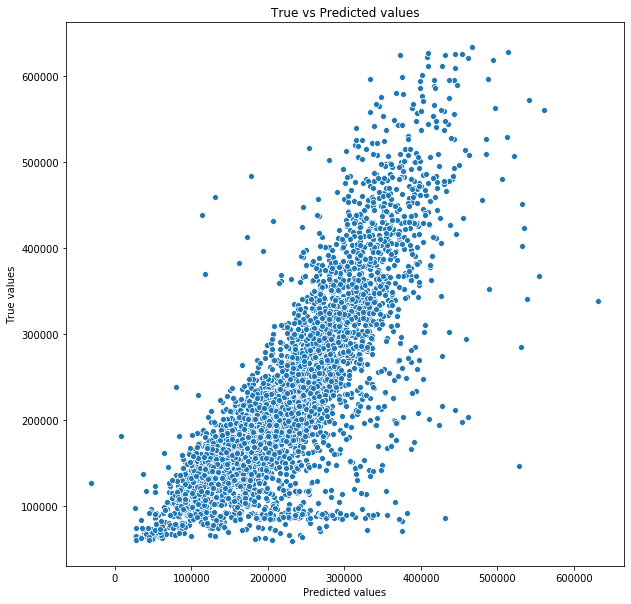

In [504]:
y_train_preds = lr_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.668
MAE:	34227.839
MSE:	2839444256.285


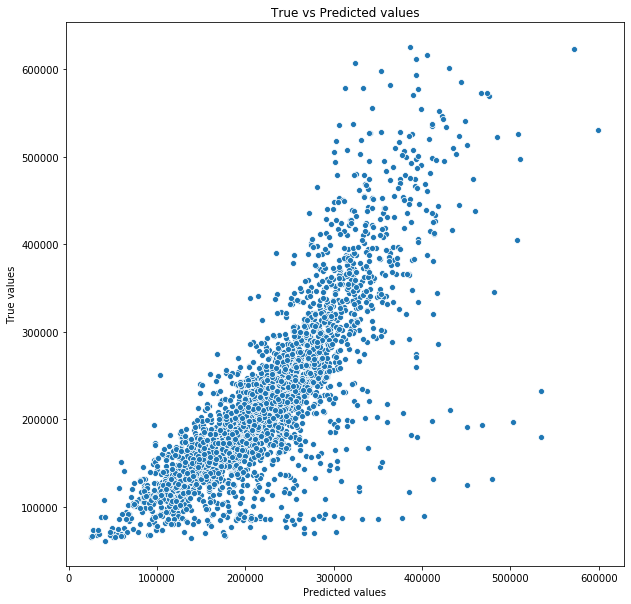

In [505]:
y_test_preds = lr_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Модель RandomForestRegressor

In [506]:
X = df[feature_names]
y = df[target_name]

In [507]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [448]:
def Grid_Search_CV_RFR(X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.ensemble import RandomForestRegressor

    estimator = RandomForestRegressor()
    param_grid = { 
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

    grid.fit(X_train, y_train)

    return grid.best_params_

In [416]:
Grid_Search_CV_RFR(X_train, y_train)


{'bootstrap': False,
 'max_features': 'log2',
 'min_samples_split': 8,
 'n_estimators': 30}

In [508]:
rf_model = RandomForestRegressor(n_estimators= 30,bootstrap=False,max_features='log2',min_samples_split=8)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=8,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.966
MAE:	10533.139
MSE:	298391247.307


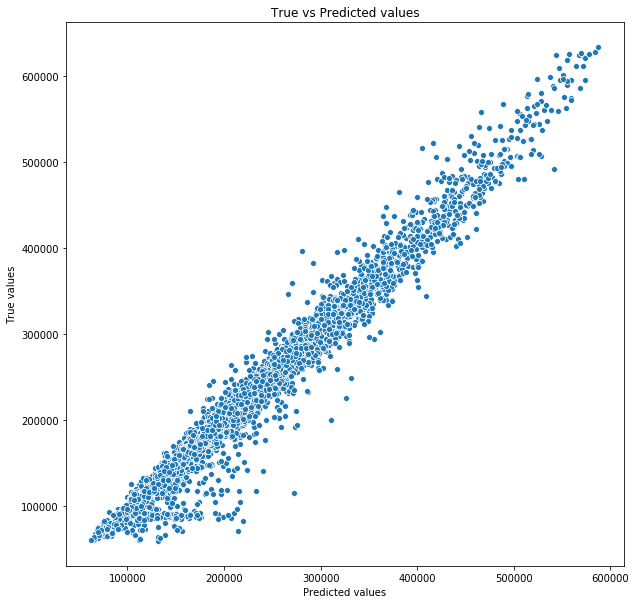

In [509]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.751
MAE:	27510.437
MSE:	2135082399.991


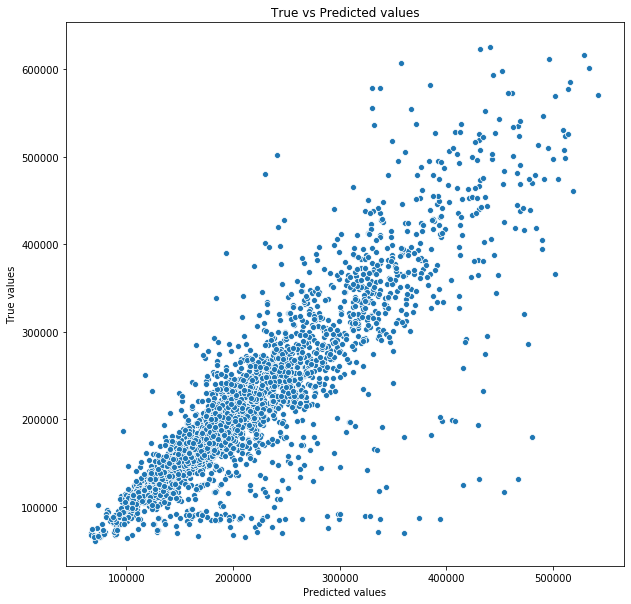

In [510]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [511]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.322416
1,value_price,0.177535
2,Rooms,0.142223
9,Social_2,0.075881
4,KitchenSquare,0.046009
10,Social_3,0.041097
7,HouseYear,0.039162
0,DistrictId,0.031261
6,HouseFloor,0.028193
11,Helthcare_2,0.026637


### Предсказание на тестовых данных

In [512]:
df_test=pd.read_csv(DATASET_TEST)
df_test_1=df_test.copy()

In [513]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [514]:
for i in val:
      df_test.loc[df_test['DistrictId']==i,'value_price']=df[df['DistrictId']==i]['value_price'].median()
     

In [515]:
converting_bin(df_test)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,value_price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,NaN,0,0,B,2955.306014,0,0,0
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,1437,3,NaN,0,2,B,3483.810063,0,0,0
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,8361.390680,0,0,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,NaN,3,3,B,3821.027752,0,0,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,NaN,0,0,A,2669.535159,0,0,1


In [516]:
df_test[df_test['value_price'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,value_price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
51,15748,212,2.0,75.655182,36.877626,15.0,2,7.0,1929,0.000000e+00,...,1423,37,562.0,1,8,B,NaN,0,0,0
1043,14939,210,2.0,54.953826,31.223917,6.0,3,10.0,1956,8.194346e-02,...,2738,20,NaN,1,4,B,NaN,0,0,0
1475,16217,206,4.0,76.428426,50.344903,11.0,7,6.0,1912,4.203159e-02,...,6856,84,1940.0,2,5,B,NaN,0,0,0
2323,9155,204,3.0,88.559337,62.854221,8.0,8,7.0,1918,3.731645e-02,...,6748,93,562.0,4,10,B,NaN,0,0,0
2370,8845,203,2.0,50.417709,27.587971,7.0,5,4.0,1977,1.501689e-02,...,3079,59,2890.0,0,8,B,NaN,0,0,0
2666,15655,211,2.0,46.501558,32.276987,5.0,5,5.0,1965,1.800000e-09,...,3681,73,1815.0,2,5,B,NaN,0,0,0
3668,13382,206,2.0,46.047289,27.384090,6.0,5,7.0,1930,7.815280e-05,...,6398,141,1046.0,3,23,B,NaN,0,0,0
4046,14024,198,2.0,47.477281,31.069466,5.0,2,5.0,1970,6.076152e-03,...,5285,0,645.0,6,6,B,NaN,0,0,0


In [517]:
df_test.loc[df_test['value_price'].isnull(),'value_price']=df_test['value_price'].median()

In [518]:
converting_bin(df_test)

In [519]:
df_test[feature_names].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
DistrictId       5000 non-null int64
value_price      5000 non-null float64
Rooms            5000 non-null float64
Square           5000 non-null float64
KitchenSquare    5000 non-null float64
Floor            5000 non-null int64
HouseFloor       5000 non-null float64
HouseYear        5000 non-null int64
Ecology_1        5000 non-null float64
Social_2         5000 non-null int64
Social_3         5000 non-null int64
Helthcare_2      5000 non-null int64
Shops_1          5000 non-null int64
Ecology_2_bin    5000 non-null int64
Ecology_3_bin    5000 non-null int64
Shops_2_bin      5000 non-null int64
dtypes: float64(6), int64(10)
memory usage: 625.1 KB


In [520]:
len(df_test[feature_names])-df_test[feature_names].count()

DistrictId       0
value_price      0
Rooms            0
Square           0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Social_2         0
Social_3         0
Helthcare_2      0
Shops_1          0
Ecology_2_bin    0
Ecology_3_bin    0
Shops_2_bin      0
dtype: int64

In [521]:
y_train_preds = rf_model.predict(df_test[feature_names])
y_train_preds

array([157223.94161923, 223750.22580901, 323126.08567954, ...,
       336847.46448446, 181128.18652475, 172454.64077794])

In [463]:
df_test['Price']=y_train_preds

In [522]:
df_test.to_csv(r'DBolshakov_predictions.csv',columns={'Id','Price'},header=True,index=False)